### Mini Project 1: Construction and Analysis of High-Risk and Low-Risk Investment Portfolios Using Modern Portfolio Theory (MPT)

# Objective:
Build and Compare two portfolios

1. High-Risk Portfolio: Emphasizes return but high volatility
2. Low-Risk Portfolio: Relatively Portfolio stability and minimizes drawdown

# Type of Risk Analyzed:
1. Volatility (Standard Deviation): Measures price fluctuation
2. Beta: Sensitivity to overall market movements
3. Value at Risk (VaR): Potential loss over a period at a given confidence level
4. Sharpe Ratio (Return/Risk): Efficiency of returns per unit of risk

# Methodology:
Pull current data (past 1 year) using yfinance
Select well-known stocks

Compute:
1. Daily returns
2. Covariance matrix
3. Portfolio returns and risk

Use optimization to get:
1. Max Sharpe (for low risk)
2. Max return (for high risk)

Plot the efficient frontier

In [3]:
import yfinance as yf
import  numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize

In [33]:

# List tickers
tickers = ['AAPL', 'MSFT', 'AMZN', 'TSLA', 'JNJ', 'XOM', 'GOOGL', 'NVDA']

# Download data
data = yf.download(tickers, start="2024-05-01", end="2025-05-01")
print(data)
# Extract only the 'Close' prices for each ticker
close_prices = data[[col for col in data.columns if col[0] == 'Close']]
close_prices.columns = [col[1] for col in close_prices.columns]  # Rename columns to ticker names
print(close_prices.head())

[*********************100%***********************]  8 of 8 completed

Price            Close                                                  \
Ticker            AAPL        AMZN       GOOGL         JNJ        MSFT   
Date                                                                     
2024-05-01  168.283646  179.000000  162.883133  145.235687  391.229401   
2024-05-02  171.991272  184.720001  165.626678  144.025223  394.102112   
2024-05-03  182.279160  186.210007  166.242981  143.400787  402.839264   
2024-05-06  180.619186  188.699997  167.097855  142.737915  409.654633   
2024-05-07  181.305023  188.759995  170.229065  142.872391  405.494110   
...                ...         ...         ...         ...         ...   
2025-04-24  208.097107  186.539993  159.087402  153.613083  386.590271   
2025-04-25  209.005920  188.990005  161.764175  153.266068  391.131958   
2025-04-28  209.864792  187.699997  160.415802  154.029526  390.443207   
2025-04-29  210.933395  187.389999  159.966354  154.584763  393.317932   
2025-04-30  212.221710  184.419998  15

In [28]:
# Returns & Risk
returns = close_price.pct_change().dropna()
mean_returns = returns.mean() * 252  # annualized
cov_matrix = returns.cov() * 252     # annualized


# Portfolio metrics
# A portfolio is just a mixed of different stocks and weights mean how much money (in %) you put in each stock
def portfolio_performance(weights, mean_returns, cov_matrix): 
    # gives the expected return of the whole portfolio
    returns = np.dot(weights, mean_returns) 
     # gives the portfolio's standard deviation (volatility = risk)
    std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) 
    return returns, std

# Negative Sharpe Ratio (for minimization)
# Sharpe = (Return − Risk-free rate) / Risk  ; measures how much return you're getting for the risk you're taking

def neg_sharpe(weights, mean_returns, cov_matrix, risk_free_rate=0.02):
    # ret and std are the expected return and standard deviation (risk) of the portfolio,
    # calculated from the helper function portfolio_performance
    ret, std = portfolio_performance(weights, mean_returns, cov_matrix) 
    # Return negative Sharpe Ratio because optimizers minimize by default
    # By minimizing the negative, we are maximizing the real Sharpe Ratio
    return -((ret - risk_free_rate) / std) 

# Max Return (High Risk)
# defines a function that calculates negative expected return of a portfolio
def max_return(weights, mean_returns, cov_matrix):
    # return the negative because the optimizer (scipy.optimize.minimize) is a minimizer
    return -np.dot(weights, mean_returns)

# Define Constraints and Bounds - which came from scipy.optimizer 
constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
bounds = tuple((0, 1) for asset in range(len(tickers)))
initial_weights = len(tickers) * [1/len(tickers)]

In [31]:
# Optimization
# Core optimization steps
# SLSQP = Sequential Least Squares Programming. It works well for smooth, continuous problems, like finance optimization
low_risk = minimize(neg_sharpe, initial_weights, args=(mean_returns, cov_matrix),
                    method='SLSQP', bounds=bounds, constraints=constraints)

high_risk = minimize(max_return, initial_weights, args=(mean_returns, cov_matrix),
                     method='SLSQP', bounds=bounds, constraints=constraints)


# Extract portfolios
# .x is the solution — gives the best weights found by the optimizer
low_risk_weights = low_risk.x
high_risk_weights = high_risk.x

# Calculate portfolio stats 
low_ret, low_vol = portfolio_performance(low_risk_weights, mean_returns, cov_matrix)
high_ret, high_vol = portfolio_performance(high_risk_weights, mean_returns, cov_matrix)

print("Low-Risk Portfolio:")
print(f"Annual Return: {low_ret:.2%}")
print(f"Volatility: {low_vol:.2%}")
print("Weights:")
print(pd.Series(low_risk_weights, index=tickers))

print("\nHigh-Risk Portfolio:")
print(f"Annual Return: {high_ret:.2%}")
print(f"Volatility: {high_vol:.2%}")
print("Weights:")
print(pd.Series(high_risk_weights, index=tickers))


Low-Risk Portfolio:
Annual Return: 26.33%
Volatility: 20.33%
Weights:
AAPL     1.255178e-01
MSFT     0.000000e+00
AMZN     2.188191e-16
TSLA     5.649917e-01
JNJ      1.419763e-16
XOM      1.532044e-01
GOOGL    1.562862e-01
NVDA     4.137587e-17
dtype: float64

High-Risk Portfolio:
Annual Return: 70.96%
Volatility: 72.21%
Weights:
AAPL     0.000000e+00
MSFT     4.838116e-16
AMZN     0.000000e+00
TSLA     0.000000e+00
JNJ      2.829949e-16
XOM      0.000000e+00
GOOGL    1.000000e+00
NVDA     3.044442e-16
dtype: float64


### Efficient Frontier
The Efficient Frontier shows: All the possible portfolios you could build by combining your selected stocks, with different 
return and risk trade-offs.\
It helps you answer:\
What mix of stocks gives me the best return for a given level of risk?\
How can I visualize all possible portfolios?

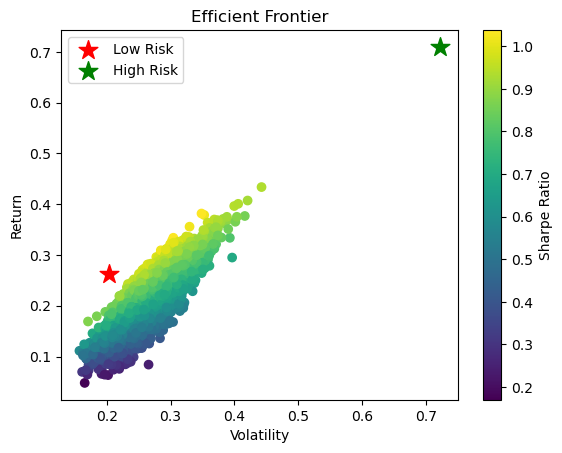

In [32]:
# Efficient Frontier

def simulate_portfolios(num_portfolios, mean_returns, cov_matrix):
    # Create an empty result tables
    results = np.zeros((3, num_portfolios))
    weights_record = []
    for i in range(num_portfolios):
        # Random numbers for each stock
        weights = np.random.random(len(tickers))
        # Normalize so they sum to 1
        weights /= np.sum(weights)
        weights_record.append(weights)
        # Calculate performance
        portfolio_return, portfolio_std = portfolio_performance(weights, mean_returns, cov_matrix)
        # Save the result
        results[0,i] = portfolio_std # Risk 
        results[1,i] = portfolio_return # Retrun 
        results[2,i] = (portfolio_return - 0.02) / portfolio_std # Sharpe Ratio , risk-free rate = 0.02
    return results, weights_record # Save the weights
    
# Run the simulations
results, weights_record = simulate_portfolios(5000, mean_returns, cov_matrix)

# Plot
plt.scatter(results[0,:], results[1,:], c=results[2,:], cmap='viridis', marker='o')
plt.xlabel('Volatility')
plt.ylabel('Return')
plt.colorbar(label='Sharpe Ratio')
plt.scatter(low_vol, low_ret, marker='*', color='r', s=200, label='Low Risk')
plt.scatter(high_vol, high_ret, marker='*', color='g', s=200, label='High Risk')
plt.legend()
plt.title('Efficient Frontier')
plt.show()